# Computational Methods in Simulation (CMIS) Week 7
This notebook is intended to help students make their hand-in in this week of CMIS.

Hand-ins must be submitted as a maximum 3 page pdf file in Absalon and must be made using the ACM TOG overleaf latex template

https://www.overleaf.com/latex/templates/association-for-computing-machinery-acm-large-2-column-format-template/qwcgpbmkkvpq

Notebooks must be uploaded as well so teachers have code solutions accessible if needed.

This week is based on Slides 21

* Hints: You might want to re-visit your FEM and FVM code pieces and reuse subparts of them for this larger project. The meshing week might prove useful for creating your own test cases to play with.

* Derive theory of how to create your own FVM simulator for simulating dynamic hyperelastic materials using a Saint-Vernant-Kirchoff model and a semi-implicit time-stepping scheme.
* Design experiments for verification and validation of your own simulator
* Present results of your experiments and discuss your findings
* If time is available try and extend the simulator to use adaptive or higher order time-stepping
* If time is available try and extend the simulator to use other types of material models
* If time is available try and extend the simulator to have dynamic boundary conditions to model "contact" when objects move around.

## Important Remark

* Do not be too agressive in terms of too large time-step size, too stiff materials and too large gravity. The semi-explicit nature of this overall method is quite sensitive, so use soft materials, almost no gravity and very small time-steps is recommended for prototyping and initial implementation. Once, it has been verified that code works, one can crank up values as close to reality as possible.

## Detailed Expected Learning Objectives in this Week

* Project (Slides 21)
    * Combine and show all skills learned through out the course.
    * Design interesting and relevant experiments for verification and validation.
    * Successfully create and discuss experimental results.
    * Demonstrate ability to scientific discuss and reflect on the simulator.
    * (Grade Catch up Opportunity to demonstrate missing learning goals now have been achieved).

In [1]:
%matplotlib widget

In [2]:
import igl
import meshplot as mp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import wildmeshing as wm

# Handling Mesh Geometry Information
In this week we may be able to resue material from previous weeks. In particular the beam mesh genreation function will be useful to us.

However, we make one important slight change to this mesh generation function to avoid ear-triangles when we ask it to generate an even number of horitonal and vertical nodes.

Ear triangles form a degenerate control volume and we do not like them for this reason. The most easy fix is to make sure we never generate ear-triangle in the first place.

In [3]:
def vec2(x,y):
    return np.array([x, y],dtype=np.float64)


def hat(p):
    return vec2(-p[1], p[0])


def compute_triangle_areas(V,T):
    E = len(T) # Total number of triangles in the mesh
    A = np.zeros((E,),dtype=np.float64)
    for e in range(E):
        # Get triangle indices
        i = T[e,0]
        j = T[e,1]
        k = T[e,2]
        # Get triangle coordinates
        xi = V[i,0]
        xj = V[j,0]
        xk = V[k,0]
        yi = V[i,1]
        yj = V[j,1]
        yk = V[k,1]    
        
        dx1 = xk - xj
        dy1 = yk - yj
        dx2 = xi - xj
        dy2 = yi - yj

        A[e] =  (dx1*dy2 - dx2*dy1 ) / 2.0
    return A


def make_beam_mesh(width, height, shape):
    x0 = -width/2.0
    y0 = -height/2.0
    I  = shape[0]
    J  = shape[1]
    dx = width/float(I)
    dy = height/float(J)
    V = np.zeros(((I+1)*(J+1),2),dtype=np.float64)
    for j in range(J+1):
        for i in range(I+1):
            k = i + j*(I+1)
            V[k,0] = x0 + i*dx
            V[k,1] = y0 + j*dy
    T = np.zeros((2*I*J,3),dtype=np.int32)
    for j in range(J):
        for i in range(I):
            k00 = (i  ) + (j  )*(I+1)
            k01 = (i+1) + (j  )*(I+1)
            k10 = (i  ) + (j+1)*(I+1)
            k11 = (i+1) + (j+1)*(I+1)
            e = 2*(i + j*I)
            if (i+j+1)%2:
                T[e,  :] = (k00,k01,k11)
                T[e+1,:] = (k00,k11,k10)
            else:
                T[e,  :] = (k10,k00,k01)
                T[e+1,:] = (k10,k01,k11)                    
    return V, T


def make_circle_mesh(radius, segments):
    K = segments
    X = np.array([ radius*np.cos(2*np.pi*k/K) for k in range(K)])
    Y = np.array([ radius*np.sin(2*np.pi*k/K) for k in range(K)])
    P = np.zeros((K,2))
    P[:,0] = X
    P[:,1] = Y
    L = np.array([(k,(k+1)%K) for k in range(K)],dtype=np.int32)
    
    V, T, _, _ = wm.triangulate_data(P, L, cut_outside=True)
    return (V, T)


Later we will need to build a data structure for our control volumes. To create the control volumes we need to be able to query the mesh about connectivity information and geometric information as well. That is things like all triangles that share the same vertex or the outward unit normals of a triangle and so on.

To make this easy we provide a MeshInfo class that encapsulates simple libigl functionality into a more human readiable interface.

It is a great help to know how to "jump" around neighbors in a mesh data structure. We encourage therefore that students spend a bit of time getting into how this works so they can extend and customize their data structures as they need to with little effort.

In [4]:
class MeshInfo:
    
    def __init__(self, V, T):        
        self.A = compute_triangle_areas(V,T)
        if np.any(np.where(self.A<=0)):
            raise ValueError('Triangle with negative orientation exist.')
        bc = igl.barycenter(V,T)
        E = igl.edges(T)
        TT, _ = igl.triangle_triangle_adjacency(T)
        VT, NI = igl.vertex_triangle_adjacency(T, len(V))
        VV = igl.adjacency_list(T)
        self.V = V    # Vertices
        self.T = T    # Triangles
        self.E = E    # Edges
        self.TT = TT  # Triangle neighbors of triangles
        self.VT = VT  # Triangle neighbors of vertices
        self.NI = NI  # Vertex neighbor indices used to extract triangle neighbors of vertices
        self.VV = VV  # Vertex neighbors of vertices
        self.bc = bc  # Barycenters of triangles        
        mask = np.zeros(len(V),dtype=np.int)
        mask[igl.boundary_loop(T)] = 1
        self.boundary_vertex = mask # Boundary mask of vertices, if 1 then a vertex is boundary otherwise it is interior.
        
    def get_triangles_of_vertex(self, i):
        start = self.NI[i]
        end = self.NI[i+1]
        return self.VT[ start:end]

    def get_triangles_of_triangle(self, t):
        return self.TT[t]
    
    def get_triangle_center(self,t):
        return self.bc[t]
    
    def get_vertices_of_vertex(self, i):
        return self.VV[i]
    
    def get_triangle_area(self,t):
        return self.A[t]
    
    def get_edge_vector_of_triangle(self, t, e):
        i = self.T[t,e]
        j = self.T[t,(e+1)%3]
        vi = self.V[i,:].flatten()
        vj = self.V[j,:].flatten()
        u = (vj-vi).flatten()
        return u, (vi+vj)/2

    def get_outward_normal_of_triangle(self, t, e):
        u, m = self.get_edge_vector_of_triangle(t,e)
        n = -hat(u)/np.linalg.norm(u)
        return n, m
    
    def get_triangle_triangle_segment(self, t, e):
        n = self.TT[t,e]
        if n>0:
            ct = self.bc[t].flatten()
            cn = self.bc[n].flatten()
            return cn-ct, (cn+ct)/2
        return None, None    

    def get_opposing_triangle(self, t, v):
        e = (v+1)%3
        return self.TT[t,e]
    
    def is_boundary_vertex(self,v):
        if self.boundary_vertex[v]==1:
            return True
        return False
    

We will now run a simplel test example of the mesh generation and mesh info data structure to verify that things are working as expected. 

In particular we want to make sure we have no ears in the mesh, and all neighborhood information are in order too.

c:\Users\pc\anaconda3\envs\cmis\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


vertex  0  has triangle neighbors  [0 1]
vertex  1  has triangle neighbors  [0 2]
vertex  2  has triangle neighbors  [2 3]
vertex  3  has triangle neighbors  [1 4]
vertex  4  has triangle neighbors  [0 1 2 3 4 5 6 7]
vertex  5  has triangle neighbors  [3 6]
vertex  6  has triangle neighbors  [4 5]
vertex  7  has triangle neighbors  [5 7]
vertex  8  has triangle neighbors  [6 7]
Triangle  0  has triangle neighbors  [-1  2  1]
Triangle  1  has triangle neighbors  [ 0  4 -1]
Triangle  2  has triangle neighbors  [ 0 -1  3]
Triangle  3  has triangle neighbors  [ 2 -1  6]
Triangle  4  has triangle neighbors  [-1  1  5]
Triangle  5  has triangle neighbors  [ 4  7 -1]
Triangle  6  has triangle neighbors  [ 3 -1  7]
Triangle  7  has triangle neighbors  [ 6 -1  5]
vertex  0  has vertex neighbors  [1, 3, 4]
vertex  1  has vertex neighbors  [0, 2, 4]
vertex  2  has vertex neighbors  [1, 4, 5]
vertex  3  has vertex neighbors  [0, 4, 6]
vertex  4  has vertex neighbors  [0, 1, 2, 3, 5, 6, 7, 8]
verte

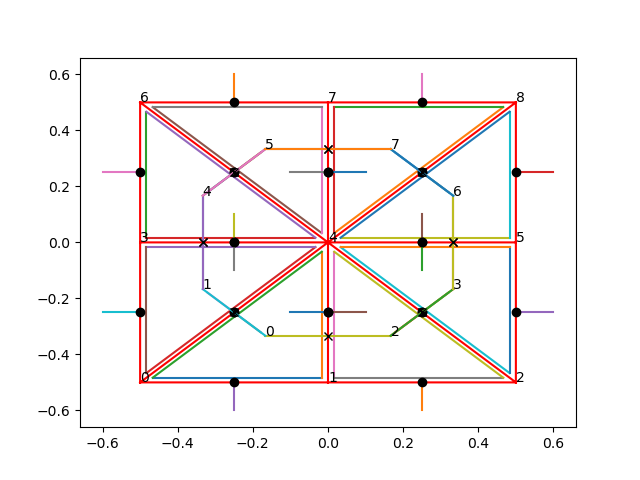

In [5]:
V, T = make_beam_mesh(1.0,1.0,(2,2))

info = MeshInfo(V,T)

fig = plt.figure()
plt.triplot(info.V[:,0],info.V[:,1],info.T,color='r')

for v in range(len(V)):
    print('vertex ',v , ' has triangle neighbors ',info.get_triangles_of_vertex(v))
    plt.text(info.V[v,0],info.V[v,1], str(v))
    
for t in range(len(T)):
    print('Triangle ',t , ' has triangle neighbors ',info.get_triangles_of_triangle(t))
    c = info.get_triangle_center(t)
    plt.text(c[0],c[1], str(t))
    
for v in range(len(V)):
    print('vertex ',v , ' has vertex neighbors ',info.get_vertices_of_vertex(v))
    
for t in range(len(T)):
    c = info.get_triangle_center(t)
    for e in range(3):
        u, m = info.get_edge_vector_of_triangle(t,e)
        v = m - 0.5*u
        w = m + 0.5*u
        m = (m-c)*0.9 + c
        v = (v-c)*0.9 + c
        w = (w-c)*0.9 + c
        plt.plot([v[0], w[0]], [v[1], w[1]] )
        
for t in range(len(T)):
    for e in range(3):
        n, m = info.get_outward_normal_of_triangle(t,e)
        plt.plot([m[0], 0.1*n[0]+m[0]], [m[1], 0.1*n[1]+m[1]] )
        plt.plot(m[0], m[1],'ko')
        
for t in range(len(T)):
    for e in range(3):
        u, m = info.get_triangle_triangle_segment(t,e)
        if not u is None: 
            v = m - 0.5*u
            w = m + 0.5*u
            plt.plot([v[0], w[0]], [v[1], w[1]] )
            plt.plot(m[0], m[1],'kx')
            
plt.show()    


# Creating Vertex-centered Control Volumes
We may now use the mesh information functionality to quickly generate a simple control volume data structure.

We will take a rather brute-force approach and simply create a chunk of vertex-related information that is very specific to the simulation method we will immplement here.

We will exploit one very smart trick here which is to make a cyclic permulation a local copy of neighboring triangles such that the first index of each triangle is the vertex that they all have in common.

This is cleaver later on at run-time as we have explicit knowledge of where the two other vertices of each triangle is located in the vertex neighborhood. Further, it enable us to deduce a CCW order of triangles around a vertex. Although in this example we have little use of this knowledge.

In [6]:
def get_cyclic_permuation(v, triangle):
    i = triangle[0]
    j = triangle[1]
    k = triangle[2]
    if i==v:
        return [i, j, k]
    if j==v:
        return [j, k, i]
    if k==v:
        return [k, i, j]
    return [-1, -1, -1]


def get_ccw_triangle_order(v, T):
    for t in range(len(T)):
        T[t,:] = get_cyclic_permuation(v, T[t,:])    
    if len(T) == 1:
        ccw_order = np.array([0], dtype=np.int).flatten()
    else:
        ccw_order = []
        next_order = -np.ones( (len(T), ), dtype=np.int )
        prev_order = -np.ones( (len(T), ), dtype=np.int )
        for s in range(len(T)):
            A = T[s,:]
            for t in range(len(T)):
                B = T[t,:]
                if A[2]==B[1]:
                    next_order[s] = t
                if A[1]==B[2]:
                    prev_order[s] = t
        if np.any(prev_order<0):
            i = np.where(prev_order<0)[0]
            while i>=0:
                ccw_order.append(i)
                i = next_order[i]
        else:
            i = 0
            ccw_order.append(i)
            i = next_order[i]
            while i>0:
                ccw_order.append(i)
                i = next_order[i]            
        ccw_order = np.array(ccw_order, dtype=np.int).flatten()
    return ccw_order
    
    
class VertexControlVolume:

    def __init__(self, v, info):
        self.v = v
        self.c = info.V[v,:].flatten()
        self.labels = info.get_triangles_of_vertex(v)
        K = len(self.labels)        
        self.K = K
        self.boundary = info.is_boundary_vertex(v)
        
        T = info.T[self.labels,:]
        for t in range(len(T)):
            T[t,:] = get_cyclic_permuation(v, T[t,:])    
        
        self.Lij = np.zeros(( K, ), dtype=np.float64 )
        self.Lik = np.zeros(( K, ), dtype=np.float64 )
        self.Nij = np.zeros(( K, 2), dtype=np.float64 )
        self.Nik = np.zeros(( K, 2), dtype=np.float64 )
        self.Sij = np.zeros(( K, 2), dtype=np.float64 )
        self.Sik = np.zeros(( K, 2), dtype=np.float64 )
        self.P = np.zeros(( K, 2), dtype=np.float64 )
        self.A = np.sum(info.A[self.labels])/3.0
        for e in range(K):
            i = T[e,0]
            j = T[e,1]
            k = T[e,2]
            
            pi = info.V[i,:]
            pj = info.V[j,:]
            pk = info.V[k,:]
            
            Eij = (pj-pi)
            Lij = np.linalg.norm(Eij)
            Nij = -hat(Eij)/Lij
            
            Eik = (pk-pi)
            Lik = np.linalg.norm(Eik)
            Nik = hat(Eik)/Lik
        
            self.Lij[e] = Lij/2
            self.Lik[e] = Lik/2
            self.Nij[e,:] = Nij
            self.Nik[e,:] = Nik
            self.Sij[e,:] = Eij/2
            self.Sik[e,:] = Eik/2
            self.P[e,:] = (pi+pj+pk)/3
            

Now we will do a little debug rendering to test if the information in the new control volume is created correctly.

c:\Users\pc\anaconda3\envs\cmis\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


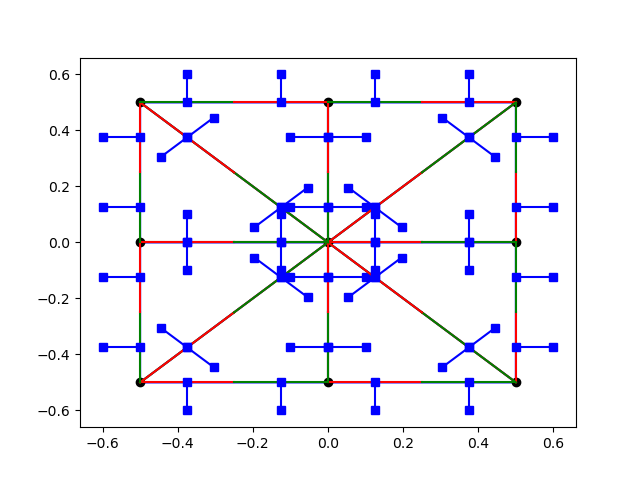

In [7]:
info = MeshInfo(V,T)

CVs = []
for v in range(len(V)):
    cv = VertexControlVolume(v,info)
    CVs.append(cv)            

fig = plt.figure()
plt.triplot(info.V[:,0],info.V[:,1],info.T,color='b')
for v in range(len(info.V)):
    cv = CVs[v]
    plt.plot(cv.c[0],cv.c[1],'ko')
    
    for e in range(cv.K):
        start = cv.c
        end = cv.c + cv.Sij[e]
        plt.plot([start[0], end[0]],[start[1], end[1]],'-r')
                   
        start = cv.c
        end = cv.c + cv.Sik[e]
        plt.plot([start[0], end[0]],[start[1], end[1]],'-g')

        start = cv.c+cv.Sij[e]/2
        end = cv.c+cv.Sij[e]/2 + cv.Nij[e]*0.1
        plt.plot([start[0], end[0]],[start[1], end[1]],'-bs')
                   
        start = cv.c+cv.Sik[e]/2
        end = cv.c+cv.Sik[e]/2 + cv.Nik[e]*0.1
        plt.plot([start[0], end[0]],[start[1], end[1]],'-bs')

plt.show()    


Next will will render the control volume shapes so we can see how they look like. They have a very specific shape and it is easy to verify by visual inspection if they have been created correctly.

c:\Users\pc\anaconda3\envs\cmis\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


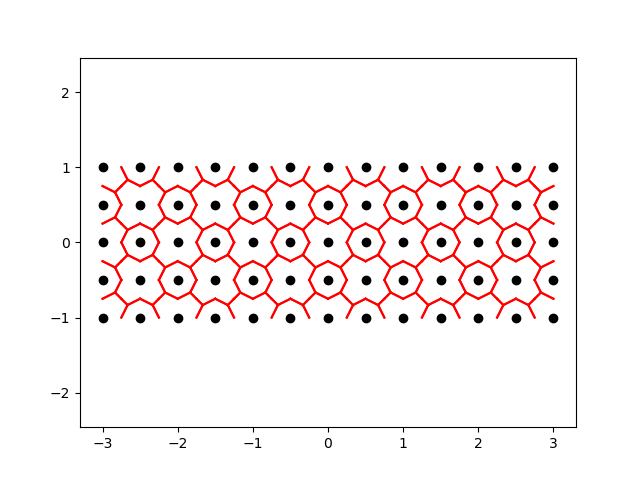

In [8]:
V, T = make_beam_mesh(6.0,2.0,(12,4))

info = MeshInfo(V,T)

CVs = []
for v in range(len(V)):
    cv = VertexControlVolume(v,info)
    CVs.append(cv)

fig = plt.figure()
ax = plt.subplot(111)
for v in range(len(CVs)):
    cv = CVs[v]
    plt.plot(cv.c[0],cv.c[1],'ko')
    for e in range(cv.K):
        start = cv.c + cv.Sij[e]
        end = cv.P[e]
        plt.plot([start[0], end[0]],[start[1], end[1]],'-r')
        start = cv.c + cv.Sik[e]
        end = cv.P[e]
        plt.plot([start[0], end[0]],[start[1], end[1]],'-r')

ax.axis('equal')
plt.show()


# Creating a 2D Hyperelastic Simulator

This is your task for the next two weeks!!!

In [9]:

def f_elastic(body, volumes, params):
    N = body.N

    fi = np.zeros((N, 2))
    strain = np.zeros((N))

    for v in range(N):
    
        cv = volumes.CVs[v]

        T = volumes.info.T[cv.labels, :]
        for t in range(len(T)):
            T[t,:] = get_cyclic_permuation(v, T[t,:])    

        for e in range(cv.K):
            i, j, k = T[e,0], T[e,1], T[e,2]

            pi = body.positions[i,:]
            pj = body.positions[j,:]
            pk = body.positions[k,:]

            Sij = (pj - pi)/2
            Sik = (pk - pi)/2
            
            de0 = np.array([cv.Sij[e], cv.Sik[e]]).T
            de0_inv = np.linalg.inv(de0)
            
            # Step 1 - Compute deformation gradients Fe for all e
            de = np.array([Sij, Sik]).T
            Fe = de @ de0_inv
            
            # Step 2 - Compute Green strain tensor Ee for all e
            Ee = (1 / 2) * (np.matmul(Fe.T, Fe) - np.identity(2))
            
            # Step 3 - Compute the PS tensor
            Se = params.lambd * np.trace(Ee) * np.identity(2) + 2 * params.mu * Ee
            
            # Step 4 - Compute 1st
            Pe = np.matmul(Fe, Se)
            
            # Step 5 - Compute elastic forces
            fi[v] = fi[v] + (-1 / 2) * Pe @ cv.Nij[e] * cv.Lij[e] - (1 / 2) * Pe @ cv.Nik[e] * cv.Lik[e]
            
            strain[v] = strain[v] + (params.lambd / 2) * np.trace(Ee) ** 2 + params.mu * np.trace(Ee * Ee)
    
    return fi, strain


def f_external(volumes, params):
    f_ext = np.zeros((volumes.N, 2))

    for v in range(volumes.N):
        cv = volumes.CVs[v]
        f_ext[v, :] = cv.A * params.rho * np.array([0, -params.g])
    
    return f_ext
    

def f_traction(body, volumes):
    N = volumes.N
    t = np.zeros((N, 2))
    
    traction = body.traction

    if traction == None:
        return t
    
    for v in range(N):
        cv = volumes.CVs[v]
        
        for e in range(cv.K):
            if cv.boundary:
                if traction.inside(body.V[cv.v] + cv.Sij[e, :]):
                    t[v] = t[v] + (traction.t * params.rho * cv.Lij[e])
                
                if traction.inside(body.V[cv.v] + cv.Sik[e, :]):
                    t[v] = t[v] + (traction.t * params.rho *cv.Lik[e])
            
    return t


def velocity_step(volumes, params, f_total):
    N = volumes.N
    steps = np.zeros((N, 2))

    for v in range(N):
        cv = volumes.CVs[v]
        
        mi = cv.A * params.rho
        steps[v] = (params.dt / mi) * f_total[v]
    
    return steps


def step(body, volumes, dirichlet, params):
    f_el, strain = f_elastic(body, volumes, params)
    f_ex = f_external(volumes, params)
    f_tr = f_traction(body, volumes)

    body.strain = strain
    body.f_elastic = f_el
    body.f_external = f_ex
    body.f_traction = f_tr

    f_total = f_ex + f_tr + f_el

    f_total = dirichlet.apply(f_total)
    
    # Step 7 - Compute velocity update
    body.velocities = body.velocities + velocity_step(volumes, params, f_total)

    # Step 8 - Compute position update
    body.positions = body.positions + params.dt * body.velocities
    


In [10]:
class Domain:
    def __init__(self, V, T):  
        self.V = V
        self.T = T
        
        N = len(V) # Number of vertices
        info = MeshInfo(V,T)

        CVs = []
        for v in range(N):
            cv = VertexControlVolume(v,info)
            CVs.append(cv)
        
        self.N = N
        self.CVs = CVs
        self.info = info

        
class Body:
    def __init__(self, V, positions, traction):
        N = len(V)
        self.N = N
        self.V = V
        self.positions = positions
        self.velocities = np.zeros((N, 2))
        
        self.traction = traction
        
        self.f_elastic  = np.zeros((N, 2))
        self.f_external = np.zeros((N, 2))
        self.f_traction = np.zeros((N, 2))
        self.strain = np.zeros((N, 2))
        
    def get_strain(self, domain, params):
        strain = 0
        for v in range(self.N):
            strain += self.strain[v] * domain.CVs[v].A
            
        return strain
    
    def get_kinetic(self, domain, params):
        kinetic = 0
        for v in range(self.N):
            mass = domain.CVs[v].A * params.rho
            velocity = np.linalg.norm(self.velocities[v])
            
            kinetic += (1/2) * (velocity ** 2) * mass
            
        return kinetic
    
    def get_potential(self, domain, params):
        potential = 0
        for v in range(self.N):
            height = self.positions[v, 1] - self.V[v, 1]
            mass = domain.CVs[v].A * params.rho
            gravity = np.linalg.norm(params.g)
            
            # https://en.wikipedia.org/wiki/Potential_energy#Potential_energy_for_near_Earth_gravity
            potential += mass * gravity * height
            
        return potential

class Parameters:
    def __init__(self, material = 'default'):
        
        library = { 'cartilage':(0.69e6, 0.018, 1000),
               'cortical bone': (16.16e9, 0.33, 1600),
               'cancellous bone': (452e6, 0.3, 1600),
               'rubber': (0.01e9, 0.48, 1050),
               'concrete': (30e9, 0.20, 2320),
               'copper': (125e9, 0.35, 8900),
               'steel': (210e9, 0.31, 7800),
               'aluminium': (72e9, 0.34, 2700),
               'glass': ( 50e9,  0.18, 2190),
               'default': (10e5, 0.3,1000)}
        
        E, nu, rho = library[material]
        self.E = E              # Young Modulus
        self.nu = nu            # Poisson ratio
        self.rho = rho          # Mass density
        self.lambd =  (E*nu) / ((1+nu)*(1-2*nu))  # Lame 1st
        self.mu     =  E/(2*(1+nu))                # Lame 2nd
        self.g = 9.81                # Gravity
        self.c = 0.0004              # vicous damping
        self.dt = 0.001              # Simulation time-step size
        self.T = 1.0                 # Total time to simulate
        self.fps = 30                # Frames per second 

class Traction:
    def __init__(self, upper_left, lower_right, t):
        self.upper_left = upper_left
        self.lower_right = lower_right
        self.t = t
        
    def inside(self, p):
        x = (self.upper_left[0] <= p[0]) and (p[0] <= self.lower_right[0])
        y = (self.upper_left[1] >= p[1]) and (p[1] >= self.lower_right[1]) 
        
        return x and y
        
        
class Dirichlet:
    def __init__(self, indices):  
        self.indices = indices
        
    def apply(self, force):
        f = np.copy(force)
        f[self.indices] = np.array([0, 0])

        return f


class Energies:
    def __init__(self, ts, strain, kinetic, potential):  
        self.ts = ts
        self.strain = strain
        self.kinetic = kinetic
        self.potential = potential
    
    
class Volumes:
    def __init__(self, ts, material_volume, volumes):  
        self.ts = ts
        self.material_volume = material_volume
        self.volumes = volumes
    
    
class Simulation:
    
    def __init__(self, params):  
        self.params = params
        
    def run(self, V, T, positions, dirichlet, traction = None):
        b = Body(V, positions, traction)
        d = Domain(V, T)
        
        ts = []
        
        strain = []
        kinetic = []
        potential = []
        
        material_volume = np.sum(d.info.A)
        volumes = []

        t = 0

        while t < self.params.T:
            step(b, d, dirichlet, self.params)

            potential.append(b.get_potential(d, self.params))
            kinetic.append(b.get_kinetic(d, self.params))
            strain.append(b.get_strain(d, self.params))
            
            v = np.sum(np.abs(compute_triangle_areas(b.positions,T)))
            volumes.append(v)
            
            ts.append(t)
            t = t + self.params.dt

        return b, Energies(ts, strain, kinetic, potential), Volumes(ts, material_volume, volumes)
        

In [11]:
def plot_force(positions, force, color):
    for i in range(len(positions)):
        p = positions[i]

        f = force[i]
        a = plt.arrow(p[0], p[1], f[0], f[1], head_width=0.07, color=color)
        
    return a

def plot_grids(b, T):
    fig = plt.figure()
    plt.triplot(b.V[:,0], b.V[:,1], T, color = 'black')
    plt.triplot(b.positions[:,0], b.positions[:,1], T, color = 'blue')

    
def plot_energies(e):
    fig = plt.figure()
    mech = np.add(np.add(e.kinetic, e.potential), e.strain)
    
    plt.plot(e.ts, e.kinetic, label = "Kinetic")
    plt.plot(e.ts, e.potential, label = "Potential")
    plt.plot(e.ts, e.strain, label = "Strain")
    plt.plot(e.ts, mech, label = "Mechanical")
    
    plt.legend()
    plt.show()
    
    
def plot_volumes(v):
    fig = plt.figure()
    
    plt.plot(v.ts, np.full(len(v.ts), v.material_volume), label = "Material Volume")
    plt.plot(v.ts, v.volumes, label = "Spatial Volume")
    
    plt.legend()
    plt.show()

    
def plot_beam(body, dirichlet_indices):
    plot_grids(body, T)
    a_ext = plot_force(body.positions, body.f_external, 'red')
    a_vel = plot_force(body.positions, body.velocities, 'blue')
    a_ela = plot_force(body.positions[dirichlet_indices], body.f_elastic[dirichlet_indices], 'green')
    plt.legend([a_ext, a_ela, a_vel], ['External', 'Elastic', 'Velocity'])

    plt.ylim(top=1.5, bottom=-3)
    plt.show()


c:\Users\pc\anaconda3\envs\cmis\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


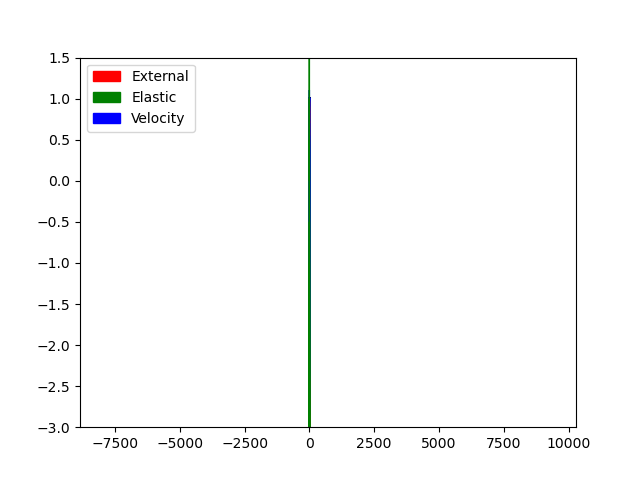

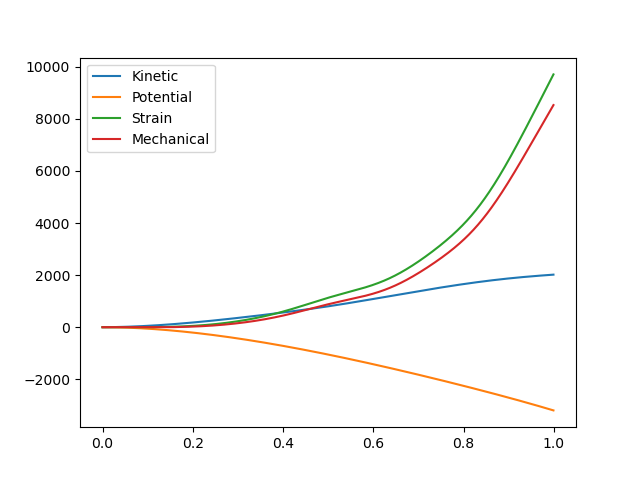

In [12]:
V, T = make_beam_mesh(6.0, 2.0, (12,4))

positions = np.copy(V)

dirichlet_indices = np.where(V[:, 0] <= -3)

params = Parameters('default')
params.g = 1.0   # Make gravity weak

d = Dirichlet(dirichlet_indices)
s = Simulation(params)

body, energies, volumes = s.run(V, T, positions, d)

plot_beam(body, dirichlet_indices)
plot_energies(energies)


c:\Users\pc\anaconda3\envs\cmis\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


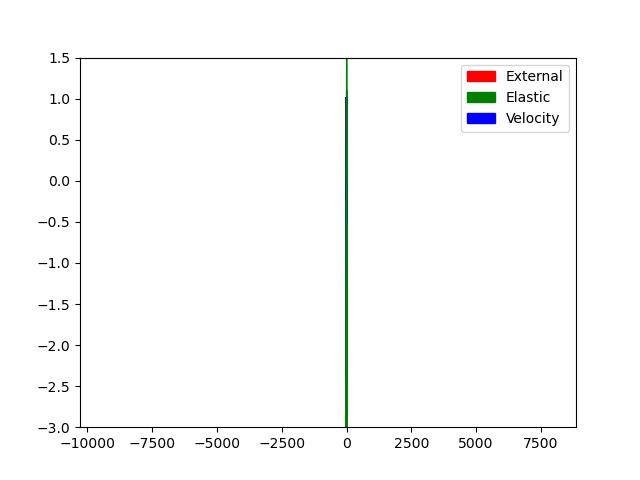

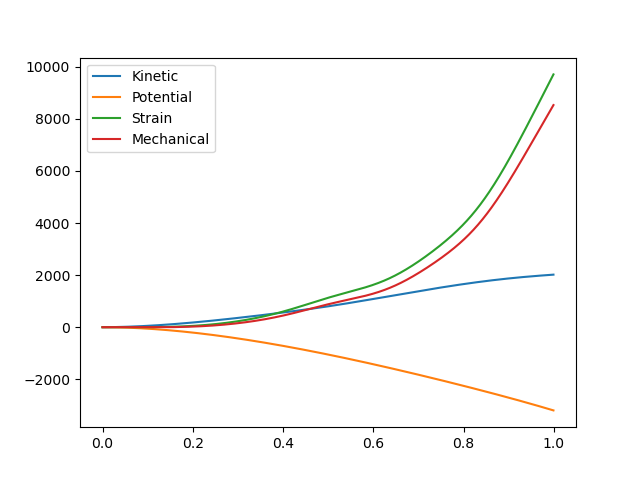

In [13]:
V, T = make_beam_mesh(6.0, 2.0, (12,4))

positions = np.copy(V)

dirichlet_indices = np.where(V[:, 0] >= 3)

params = Parameters('default')
params.g = 1.0   # Make gravity weak

d = Dirichlet(dirichlet_indices)
s = Simulation(params)

body, energies, volumes = s.run(V, T, positions, d)

plot_beam(body, dirichlet_indices)
plot_energies(energies)

c:\Users\pc\anaconda3\envs\cmis\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


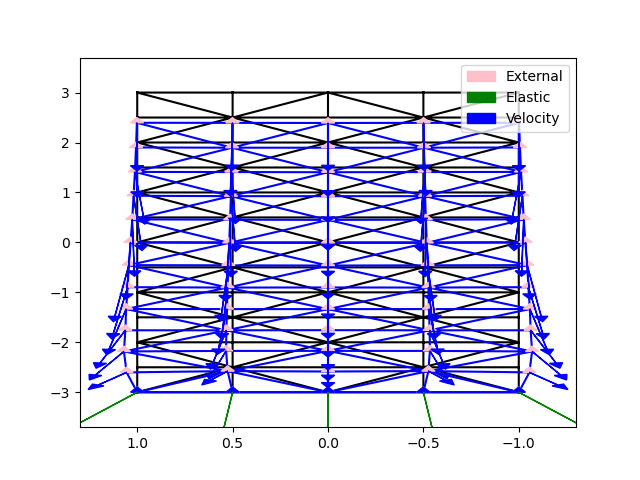

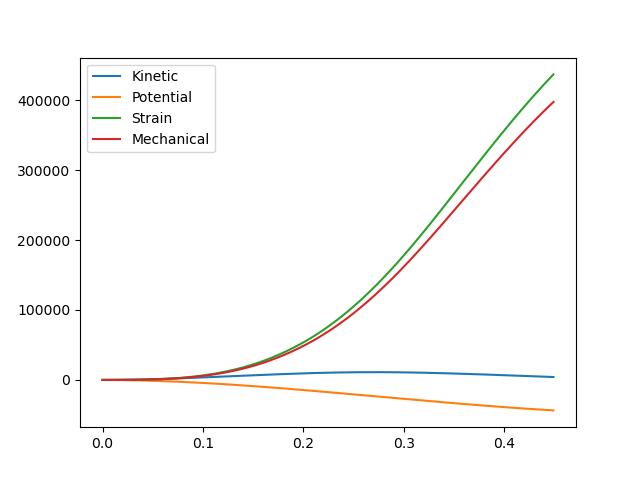

In [14]:
V, T = make_beam_mesh(2.0, 6.0, (4, 12))

positions = np.copy(V)

dirichlet_indices = np.where(V[:, 1] <= -3)

params = Parameters('default')
params.g = 9
params.T = 0.45

d = Dirichlet(dirichlet_indices)
t = Traction((-1.1, 3.25), (1.1, 2.75), np.array([0, 0]))
s = Simulation(params)

body, energies, volumes = s.run(V, T, positions, d, t)

plot_grids(body, T)
a_tra = plot_force(body.positions, body.f_traction, 'pink')
a_vel = plot_force(body.positions, body.velocities, 'blue')
a_ela = plot_force(body.positions[dirichlet_indices], body.f_elastic[dirichlet_indices], 'green')
plt.legend([a_tra, a_ela, a_vel], ['External', 'Elastic', 'Velocity'])

plt.xlim(left = 1.3, right = -1.3)
plt.ylim(top = 3.7, bottom = -3.7)
plt.show()

plot_energies(energies)


c:\Users\pc\anaconda3\envs\cmis\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


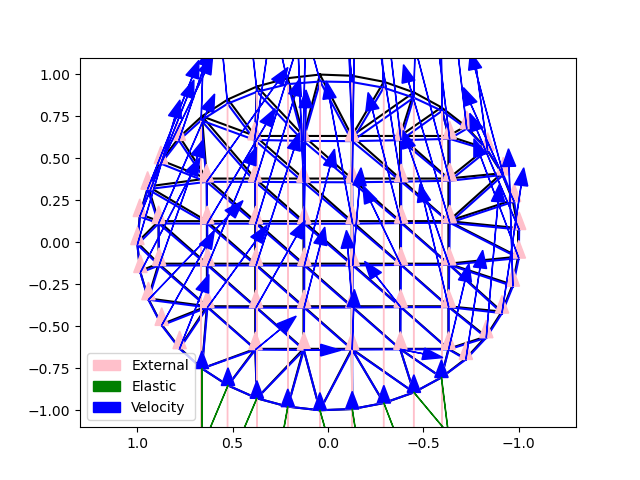

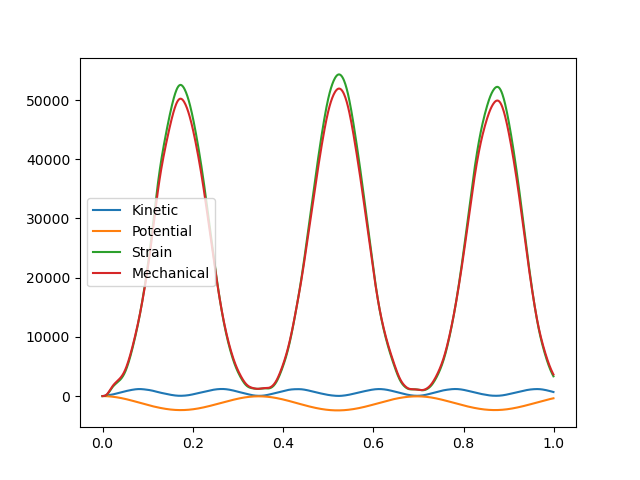

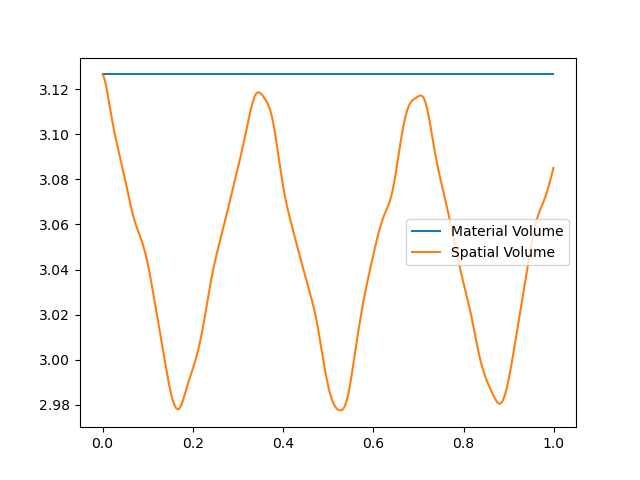

In [15]:
V, T = make_circle_mesh(1, 37)

positions = np.copy(V)

dirichlet_indices = np.where(V[:, 1] <= -0.75)

params = Parameters('default')
params.g = 9
params.T = 1

d = Dirichlet(dirichlet_indices)
t = Traction((-1.1, 1.25), (1.1, 0.75), np.array([0, -4]))
s = Simulation(params)

body, energies, volumes = s.run(V, T, positions, d, t)

plot_grids(body, T)
a_tra = plot_force(body.positions, body.f_traction, 'pink')
a_vel = plot_force(body.positions, body.velocities, 'blue')
a_ela = plot_force(body.positions[dirichlet_indices], body.f_elastic[dirichlet_indices], 'green')
plt.legend([a_tra, a_ela, a_vel], ['External', 'Elastic', 'Velocity'])

plt.xlim(left = 1.3, right = -1.3)
plt.ylim(top = 1.1, bottom = -1.1)
plt.show()

plot_energies(energies)
plot_volumes(volumes)